# How to explain a model's classification
Here we will use a variant of Locally Interpretable Model-Agnostic Explanations ("LIME", Ribeiro, M. T., Singh, S., & Guestrin, C. (2016). "Why Should I Trust You?" Explaining the Predictions of Any Classifier. Retrieved from http://arxiv.org/abs/1602.04938) to see why a model classifies a given instance.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import scipy
import sklearn.linear_model

from matplotlib import pyplot

import os

from caffe2.proto import caffe2_pb2
import caffe2.python.predictor.predictor_exporter as pe
from caffe2.python import (
    brew,
    core,
    utils,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

### Build a minidb dataset of segmented variations from one patch
The LIME method explains classification of one single instance, using a model that is trained on some set of instances.  It creates modified versions of that instance to determine which parts are most important for classifying it.

First, we will load a single instance (a field image patch).  Then we will segment it and use the segments to create the variants.  Each variant will have "missing segments".  We will then fit a Ridge Regression model to the new variant predictions to find the most important segments of the image.

In [3]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    data_uint8, label = brew.db_input(
        model,
        blobs_out=["data_uint8", "label"],
        batch_size=batch_size,
        db=db,
        db_type=db_type,
    )
    ### load the data from db - Method 2 using TensorProtosDB
    #data_uint8, label = model.TensorProtosDBInput(
    #    [], ["data_uint8", "label"], batch_size=batch_size,
    #    db=db, db_type=db_type)
    
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

In [4]:
arg_scope = {"order": "NCHW"}
loader_model = model_helper.ModelHelper(name="geo_loader", arg_scope=arg_scope)

In [5]:
data_folder = 'data'

In [6]:
ntest = 4000
data, label = AddInput(
    loader_model, batch_size=ntest,
    db=os.path.join(data_folder, 'geo_test.minidb'),
    db_type='minidb')

In [7]:
workspace.RunNetOnce(loader_model.param_init_net)
workspace.CreateNet(loader_model.net, overwrite=True)

True

#### The loader model will simply load and transform the test data.

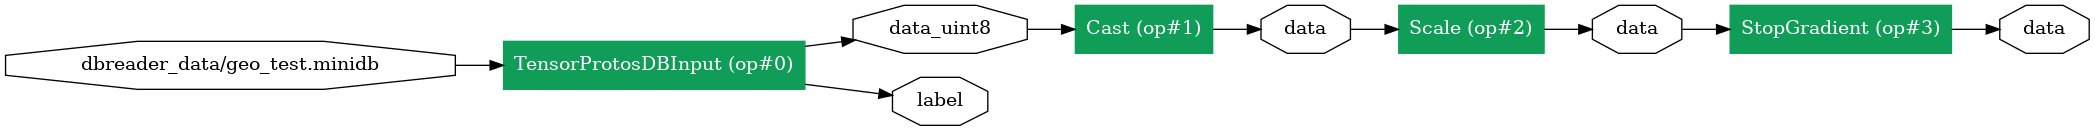

In [8]:
from IPython import display
graph = net_drawer.GetPydotGraph(loader_model.net.Proto().op, "geo", rankdir="LR")
display.Image(graph.create_png(), width=800)

In [9]:
workspace.RunNet(loader_model.net)

True

In [10]:
data = workspace.FetchBlob('data')
data.shape

(4000, 3, 60, 60)

In [11]:
label = workspace.FetchBlob('label')
label.shape

(4000,)

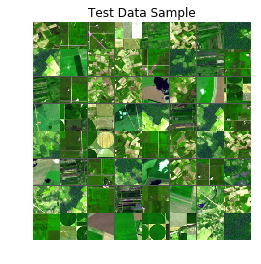

In [12]:
pyplot.figure()
pyplot.title("Test Data Sample")
_ = visualize.NCHW.ShowMultiple(data[:64])

## Segment the field image patch
Here we will pull a single patch from the Kansas field image, and break it into segments.

In [13]:
from skimage import segmentation

In [14]:
explain_patch_idx = 23 #select an arbitrary patch id to work on

In [15]:
patch = np.moveaxis(data[explain_patch_idx],0,-1)

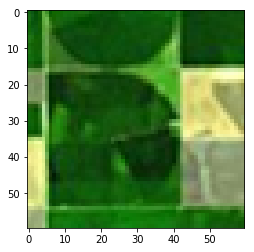

In [16]:
plt.imshow(patch)

In [17]:
segs = segmentation.quickshift(patch,max_dist=10)

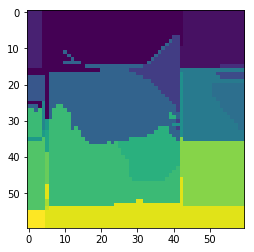

In [18]:
plt.imshow(segs)

These are the field patch segments.

Next, we will define variants of the image with random segments missing (RGB values set to zero).

In [19]:
nsegs = range(2,4)
vars_per_nsegs = 100

In [20]:
segids = sorted(set(segs.flatten()))
len(segids)

23

In [21]:
np.random.seed(123)
segment_samples = [
    np.array([segid]) for segid in segids # each segment alone
]
for nseg in nsegs:
    segment_samples += list(set([
        tuple(np.random.choice(segids,nseg)) for _ in range(vars_per_nsegs) # groups of 2-3 segments
    ]))
segment_samples = [np.array(segment_samples[_]) for _ in np.random.permutation(range(len(segment_samples)))]
len(segment_samples)

216

In [22]:
masked_patches = []
dists = []
for seg_sample in segment_samples:
    mask = np.ones(patch.shape)
    mask[np.in1d(segs,seg_sample).reshape(segs.shape)] = 0
    masked_patch = patch*mask
    masked_patches.append(masked_patch)
    dists.append(scipy.spatial.distance.euclidean(patch.flatten(),masked_patch.flatten()))
dists = np.array(dists)
masked_patches = np.array(masked_patches)
masked_patches.shape

(216, 60, 60, 3)

In [23]:
masked_patches = np.moveaxis(masked_patches,-1,1)
masked_patches.shape

(216, 3, 60, 60)

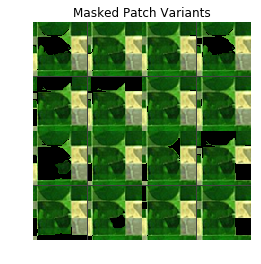

In [24]:
pyplot.figure()
pyplot.title("Masked Patch Variants")
_ = visualize.NCHW.ShowMultiple(masked_patches[:16])

These are some image variants with missing (black) segments.  Some variants are missing more than others.

## Predict on the variations
Next we simply feed the variations to the model and get its predictions for each.

In [25]:
# load the predict net
predict_net = pe.prepare_prediction_net(os.path.join(data_folder, "geo_model.minidb"), "minidb")

# verify that blobs are loaded back
print("The blobs in the workspace after loading the model: {}".format(workspace.Blobs()))


The blobs in the workspace after loading the model: [u'!!META_NET_DEF', u'!!PREDICTOR_DBREADER', u'accuracy', u'conv0', u'conv0_b', u'conv0_w', u'conv1', u'conv1_b', u'conv1_w', u'conv2', u'conv2_b', u'conv2_w', u'data', u'data_uint8', u'dbreader_data/geo_test.minidb', u'fc3', u'fc3_b', u'fc3_w', u'label', u'loss', u'pool0', u'pool1', u'pool2', u'pred', u'pred_b', u'pred_w', u'relu3', u'softmax']


In [26]:
# feed the previously saved data to the loaded model
workspace.FeedBlob("data", masked_patches.astype(np.float32))

True

In [27]:
# predict
workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob("softmax")

print("Shape of softmax: ",softmax.shape)

('Shape of softmax: ', (216, 6))


The predictions are the softmax scores for Kansas, column 3:

In [28]:
preds = softmax[:,3]

### Fit a Ridge Regression
LIME prescribes a weighted regression based on how similar each variant is to the original.

Text(0,0.5,'weight')

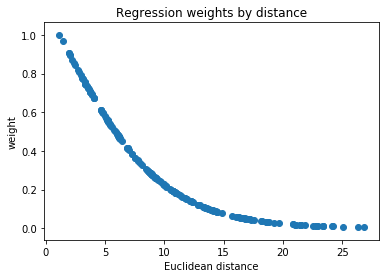

In [29]:
dist_weights = 2.0 * (1.0 - scipy.special.expit(6.0 * (dists-dists.min()) / (dists.max()-dists.min())))
plt.scatter(dists,dist_weights)
plt.title('Regression weights by distance')
plt.xlabel('Euclidean distance')
plt.ylabel('weight')

In [30]:
masked_segments = []
for seg_sample in segment_samples:
    segmask = np.zeros(len(segids))
    segmask[seg_sample] = 1
    masked_segments.append(segmask)
masked_segments = np.array(masked_segments)
masked_segments.shape

(216, 23)

In [31]:
reg = sklearn.linear_model.Ridge(alpha=1)
reg.fit(masked_segments,preds,sample_weight=dist_weights)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Text(0.5,1,'Ridge Regression:  Segments effect on Prediction')

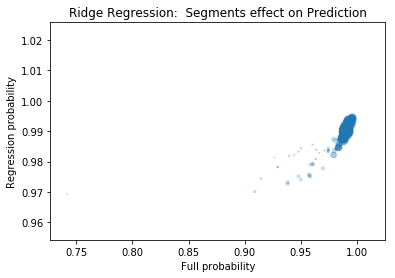

In [32]:
def markersize(wts):
    return 1+199*(wts-wts.min())/(wts.max()-wts.min())

plt.scatter(preds,reg.predict(masked_segments),s=markersize(dist_weights),alpha=.2)
plt.xlabel('Full probability')
plt.ylabel('Regression probability')
plt.title('Ridge Regression:  Segments effect on Prediction')

The fitted regression, with weights shown as point size.

## Ridge Regression Coefficients Explain the Classification
The regression has fit a coefficient for each segment of the image.  Next we will inspect the coefficients to identify the most important segments for classifiation.

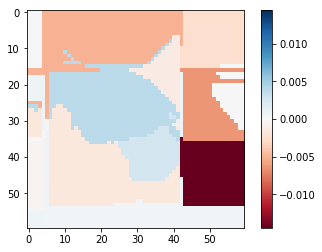

In [33]:
segment_coefs = np.zeros(segs.shape)
for segid in range(len(reg.coef_)):
    segment_coefs[segs==segid] = reg.coef_[segid]

extreme = np.abs(reg.coef_).max()
plt.imshow(segment_coefs,cmap='RdBu',vmin=-extreme,vmax=extreme)

plt.colorbar()

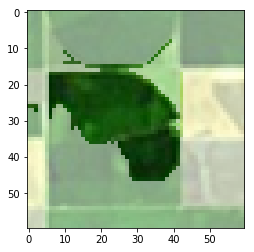

In [34]:
alpha_patch = np.concatenate((patch,.5*np.ones(patch.shape)[:,:,:1]),-1)
top_segs = reg.coef_.argsort()[::-1][:3]
highlight_mask_x,highlight_mask_y = np.where(np.in1d(segs,top_segs).reshape(segs.shape))
alpha_patch[highlight_mask_x,highlight_mask_y,-1] = 1
plt.imshow(alpha_patch)